![title](qgr.png)

### Welcome to Quant Guild Research!

In this notebook we will be walking you through the Bachelier model, prior knowledge in stochastic calculus is reccommended!  

Let us start by introducing the problem space:

Suppose we had a European option on a futures contract, how should we go about pricing such an instrument?

Well first, before even modeling the derivative's payoff, we must assume a model for the underyling - in this case we will assume the Bachlier model.

<b> Brief history lesson! </b>

Louis Bachelier's PhD thesis titled "The Theory of Speculation" (1900) was the first of its kind to use arithmetic Brownian motion in this fashion.  Shortly thereafter Black-Scholes (1973) fell into favor as geometric Brownian motion prevented asset price paths from negativity.  In April 2020 Oil futures went negative for the first time in history leaving many traders to resort to the Bachelier model to compute their portfolio sensativities!

<b> The Bachelier Model</b>

$$dF_t = \sigma dW_t, \text{ }\text{ } t \in [0, T]$$

Where 

- $F_t$ is the forward price at time $t$

- $\sigma$ is the Bachelier volatility term

- $W_t$ is standard Brownian motion

We can trivially solve for $F_T$, think of 0 $\rightarrow$ T as a step in time

$$\int_{0}^{T}dF_t = \int_{0}^{T} \sigma dW_t$$

$$F_T - F_0 = \sigma (W_T - W_0)$$

$$F_T = F_0 + \sigma W_T$$

This is quite easy to simulate in Python using some basic packages, let's create a function to simulate Bachelier paths!

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def bachelier_paths(F_0, sigma, dt, T, n):
    paths = []
    
    for i in range(n):
        t_index = 0
        prices = [F_0]
        
        while (t_index + dt) < T:
                prices.append(prices[-1]+sigma*np.random.randn()*np.sqrt(dt))
                t_index += dt
        if t_index < T:
            prices.append(prices[-1]+sigma*np.random.randn()*np.sqrt((T-t_index)))
        
        paths.append(prices)
    
    return paths

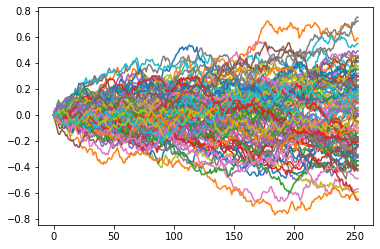

In [7]:
for path in (bachelier_paths(0, .3, 1/252, 1, 100)):
    plt.plot(path)

Cool!  Now we have a function to generate Bachelier sample paths - let's see about deriving a solution to the derivative we posited earlier.

We get our standard hockeystick diagram for an option at terminal time $T$

$$C_T = max((F_T - K), 0) = (F_T - K)^+$$

The call price today is given by the expectation of the future
$$C_0 = \mathbb{E}[(F_T-K)^+]$$

$$=\mathbb{E}[(F_0 + \sigma W_T - K)^+]$$

$$=\mathbb{E}[(F_0 - \sigma \sqrt{(T - 0)} Z - K)^+]$$

Where if you recall from Brownian motion we have independent stationary increments with mean zero and variance $dt$ thus $Z \sim N(0, 1)$

$$=\mathbb{E}[(F_0 - K - \sigma \sqrt{(T)} Z)^+]$$

Recall indicator functions as they will be very useful here
$$\mathbb{1}(x) = \begin{cases} 
      1 & \text{condition of }x \\
      0 & \sim \text{condition of }x
   \end{cases}
$$

Replace the max with the outcome of the indicator function to satisfy the same condition

$$\mathbb{1}(Z) = \begin{cases} 
      1 & Z \leq \frac{F_0 - K}{\sigma \sqrt{(T)}} \\
      0 & Z > \frac{F_0 - K}{\sigma \sqrt{(T)}}
   \end{cases}
$$

We can substitute this in

$$=\mathbb{E}[((F_0 - K - \sigma \sqrt{(T)} Z))\mathbb{1}_{Z \leq \frac{F_0 - K}{\sigma \sqrt{(T)}}}]$$

Distributing the indicator function yields

$$=\mathbb{E}[(F_0 - K)\mathbb{1}_{Z \leq \frac{F_0 - K}{\sigma \sqrt{(T)}}} - \sigma \sqrt{(T)} Z)\mathbb{1}_{Z \leq \frac{F_0 - K}{\sigma \sqrt{(T)}}}]$$

The first term indicator function can be substituted for the normal cumulative distribution, $\Phi$, up to the indicator function value

$$=(F_0 - K)\Phi(\frac{F_0 - K}{\sigma \sqrt{(T)}}) - \sigma \sqrt{(T)} \mathbb{E}[Z\mathbb{1}_{Z \leq \frac{F_0 - K}{\sigma \sqrt{(T)}}}]$$

Do recall the following property of a normal distribution

$$\Phi ' (x) = -x \phi(x)$$

Where $\phi$ is the probability density function of the normal distribution

$$\phi(x) = \frac{1}{\sqrt{2 \pi}}e^{\frac{- x^2}{2}}$$

Let's see an example of this

$$\mathbb{E}[Z\mathbb{1}_{Z \leq y}] = \int_{- \infty}^y x \phi(x) dx = -\phi(y)$$

Letting $y = \frac{F_0 - K}{\sigma \sqrt{(T)}}$ means we end up with the following value for a call price under Bachelier

$$C_0 = (F_0 - K)\Phi(\frac{F_0 - K}{\sigma \sqrt{(T)}}) + \sigma \sqrt{(T)} \phi(\frac{F_0 - K}{\sigma \sqrt{(T)}})$$

Let's create a pricing function for the closed form solution.

In [19]:
from scipy.stats import norm

def bachelier_call(F_0, K, sigma, T):
    num = F_0 - K
    den = sigma*np.sqrt(T)
    d1 = num/den
    cdf = norm.cdf(d1)
    pdf = norm.pdf(d1)
    
    return (num*cdf + den*pdf)

In [37]:
print('Bachelier Call Price: ', bachelier_call(55, 55, .15, 1))

Bachelier Call Price:  0.0598413420602149


<i> Note: The Bachlier volatility term IS different from the Black-Scholes volatility term, see the following relation</i>

$$dF_t = \sigma_N dW_t$$
$$dS_t = \sigma S_t dW_t$$

$$ \text{Thus } \sigma_N \approx \sigma S_t$$

Now that we have a pricing solution let's see if we can verify it using the Monte Carlo pricing technique.

In [45]:
paths = bachelier_paths(55, .15, 1/252, 1, 1000)

K = 55

payoffs = []

# Compute call payoffs
for path in paths:
    if(path[-1] > K):
        payoffs.append(path[-1] - K)
    else:
        payoffs.append(0)
        
print('Average Payoff of 1000 Sample Paths: ', np.mean(payoffs))

Average Payoff of 1000 Sample Paths:  0.05665518045814423


In [46]:
print('MAE of MC Price and Analytical Price: ', np.round(np.abs(np.mean(payoffs) - bachelier_call(55, 55, .15, 1)), 4))

MAE of MC Price and Analytical Price:  0.0032


Thus we have validated our pricing solution!

#### If you are interested in a formal walkthrough feel free to check out the following video

https://www.youtube.com/watch?v=J1sBj9K-BhE&t=904s

© 2022, Quant Guild